# Initialization

Automatically search for an NVIDIA GPU and use it. If not, then use CPU

In [1]:
import torch


# Find and use the appropriate GPU/CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

Using GPU


Load all of our preprocessed data from the caches that we generated with the `../preprocessing/sdt/gasdb/create_sdt.py` and `../preprocessing/split_data_gasdb.ipynb` files.

In [2]:
import pickle


# Label to use for this model in the plots
model_name = 'NN ensemble'

# Load the data split from our Jupyter notebook cache
with open('../preprocessing/sdt/gasdb/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

docs_train, docs_val, docs_test = splits['docs_train'], splits['docs_val'], splits['docs_test']
sdts_train, sdts_val, sdts_test = splits['sdts_train'], splits['sdts_val'], splits['sdts_test']
targets_train, targets_val, targets_test = splits['targets_train'], splits['targets_val'], splits['targets_test']

# Train
It takes a few hours to fit the 5-model ensemble. Since it took awhile, we ended up using a Python script and submitted it as a "job" on our high-performing-computer center via `sbatch submit_ensemble_fitting.sh`. Here is what the Python script contains.
```
import pickle
import numpy as np
from sklearn.model_selection import KFold
import torch
from torch.optim import Adam
import skorch.callbacks.base
from skorch.callbacks import Checkpoint  # needs skorch >= 0.4
from skorch.callbacks.lr_scheduler import LRScheduler
from skorch import NeuralNetRegressor
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


# Find and use the appropriate GPU/CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')


# Load the data split from our Jupyter notebook cache
with open('../preprocessing/sdt/gasdb/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)
with open('../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)
sdts_train, sdts_val = splits['sdts_train'], splits['sdts_val']
targets_train, targets_val = splits['targets_train'], splits['targets_val']


class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./histories/%i_valid_best_params.pt' % k)


# Fold the CV data
k_folder = KFold(n_splits=5)
for k, (indices_train, _) in enumerate(k_folder.split(sdts_train)):
    stds_train_ = [sdts_train[index] for index in indices_train]
    targets_train_ = np.array([targets_train[index] for index in indices_train])

    # Define various callbacks and checkpointers for this network
    LR_schedule = LRScheduler('MultiStepLR', milestones=[75], gamma=0.1)
    cp = Checkpoint(monitor='valid_loss_best', fn_prefix='./histories/%i_valid_best_' % k)
    load_best_valid_loss = train_end_load_best_valid_loss()

    # Train this fold's network
    net = NeuralNetRegressor(
        CrystalGraphConvNet,
        module__orig_atom_fea_len=orig_atom_fea_len,
        module__nbr_fea_len=nbr_fea_len,
        batch_size=214,
        module__classification=False,
        lr=0.0056,
        max_epochs=100,
        module__atom_fea_len=46,
        module__h_fea_len=83,
        module__n_conv=8,
        module__n_h=4,
        optimizer=Adam,
        iterator_train__pin_memory=True,
        iterator_train__num_workers=0,
        iterator_train__collate_fn=collate_pool,
        iterator_train__shuffle=True,
        iterator_valid__pin_memory=True,
        iterator_valid__num_workers=0,
        iterator_valid__collate_fn=collate_pool,
        iterator_valid__shuffle=False,
        device=device,
        criterion=torch.nn.L1Loss,
        dataset=MergeDataset,
        callbacks=[cp, load_best_valid_loss, LR_schedule]
    )
    net.initialize()
    net.fit(stds_train_, targets_train_)
```

We load the results here.

In [3]:
import numpy as np
from sklearn.model_selection import KFold
from torch.optim import Adam
import skorch.callbacks.base
from skorch.callbacks import Checkpoint  # needs skorch >= 0.4
from skorch.callbacks.lr_scheduler import LRScheduler
from skorch import NeuralNetRegressor
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./histories/%i_valid_best_params.pt' % k)

nets = []
# Fold the CV data
k_folder = KFold(n_splits=5)
for k, (indices_train, _) in enumerate(k_folder.split(sdts_train)):
    stds_train_ = [sdts_train[index] for index in indices_train]
    targets_train_ = np.array([targets_train[index] for index in indices_train])

    # Define various callbacks and checkpointers for this network
    LR_schedule = LRScheduler('MultiStepLR', milestones=[75], gamma=0.1)
    cp = Checkpoint(monitor='valid_loss_best', fn_prefix='./histories/%i_valid_best_' % k)
    load_best_valid_loss = train_end_load_best_valid_loss()

    # Train this fold's network
    net = NeuralNetRegressor(
        CrystalGraphConvNet,
        module__orig_atom_fea_len=orig_atom_fea_len,
        module__nbr_fea_len=nbr_fea_len,
        batch_size=214,
        module__classification=False,
        lr=0.0056,
        max_epochs=100,
        module__atom_fea_len=46,
        module__h_fea_len=83,
        module__n_conv=8,
        module__n_h=4,
        optimizer=Adam,
        iterator_train__pin_memory=True,
        iterator_train__num_workers=0,
        iterator_train__collate_fn=collate_pool,
        iterator_train__shuffle=True,
        iterator_valid__pin_memory=True,
        iterator_valid__num_workers=0,
        iterator_valid__collate_fn=collate_pool,
        iterator_valid__shuffle=False,
        device=device,
        criterion=torch.nn.L1Loss,
        dataset=MergeDataset,
        callbacks=[cp, load_best_valid_loss, LR_schedule]
    )
    net.initialize()
    net.load_params(f_history='./histories/%i_valid_best_history.json' % k,
                    f_optimizer='./histories/%i_valid_best_optimizer.pt' % k, 
                    f_params='./histories/%i_valid_best_params.pt' % k)
    nets.append(net)

## Ensembling
Wrap the five networks together

In [4]:
class Ensemble:
    def __init__(self, networks):
        self.networks = networks

    def predict(self, features):
        # Make the prediction for this network
        for net in self.networks:
            prediction = net.predict(features)

            # Concatenate this network's predictions with the previous ones
            try:
                predictions = np.hstack((predictions, prediction))

            # If this is the first network to make predictions,
            # then initialize the `predictions` output
            except NameError:
                predictions = prediction
        return predictions


ensemble = Ensemble(nets)

# Assess performance
## Validation
We used the results in this section to tune hyperparameters

In [5]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 7.5/3  # 1/3 of a page
fontsize = 20
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

CPU times: user 7.14 s, sys: 227 ms, total: 7.36 s
Wall time: 5.25 s
R2 = 0.81
PPMCC = 0.90


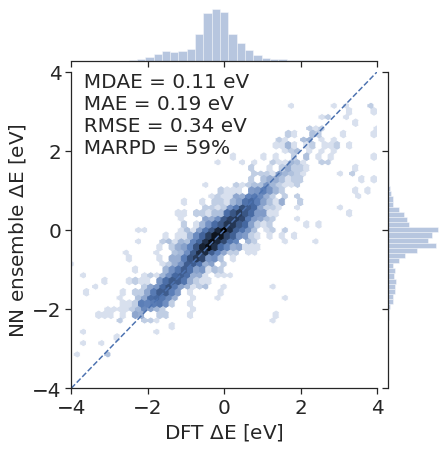

In [6]:
import numpy as np
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)


# Make the predictions
%time predictions = ensemble.predict(sdts_val)
targets_pred = predictions.mean(axis=1)
residuals = targets_pred - targets_val.reshape(-1)
stdevs = predictions.std(axis=1)

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
mdae = median_absolute_error(targets_val, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred) + np.abs(targets_val.reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_val, targets_pred)
corr = np.corrcoef(targets_val.reshape(-1), targets_pred)[0, 1]

# Report
text = ('  MDAE = %.2f eV\n' % mdae + 
        '  MAE = %.2f eV\n' % mae + 
        '  RMSE = %.2f eV\n' % rmse + 
        '  MARPD = %i%%\n' % marpd)
print('R2 = %.2f' % r2)
print('PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize)

In [7]:
%load_ext ipycache

/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [8]:
%%cache calibration_val.pkl predicted_pi observed_pi

import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


def calculate_density(percentile):
    num_within_quantile = 0
    for stdev, resid in zip(stdevs, residuals):
        norm = stats.norm(loc=0, scale=stdev)
        lower_bound = norm.ppf(0.5-percentile/2)
        upper_bound = norm.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 20)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

[Skipped the cell's code and loaded variables observed_pi, predicted_pi from file '/global/project/projectdirs/m2755/ktran/sandbox/uncertainty_benchmarking/CGCNN_ensemble/calibration_val.pkl'.]



In [9]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

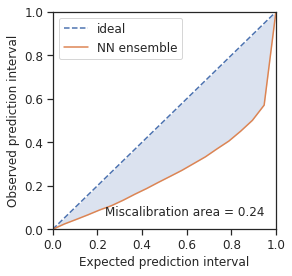

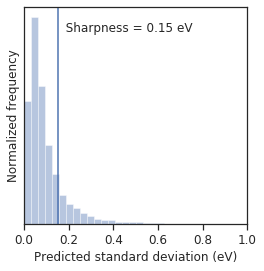

In [10]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon


# Plot settings
figsize = (width, width)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
miscalibration_area = polygon.area

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.2f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=fontsize)


# Plot sharpness curve
xlim = [0, 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviation (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV' % sharpness
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  ' % sharpness
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align,
                  fontsize=fontsize)

## Test
We never actually made the predictions during the job, so we have to make the predictions here.

In [11]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 7.5/3  # 1/3 of a page
fontsize = 20
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

CPU times: user 8.62 s, sys: 202 ms, total: 8.82 s
Wall time: 6.05 s
R2 = 0.82
PPMCC = 0.90


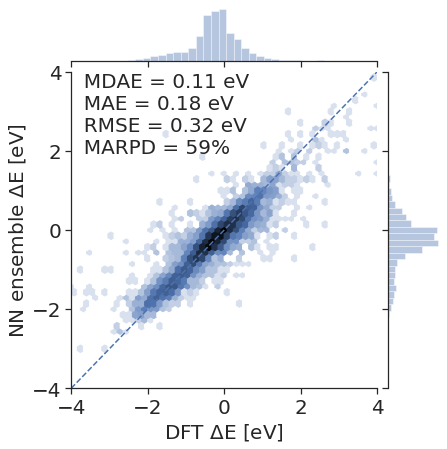

In [12]:
%matplotlib inline
import numpy as np
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)
import matplotlib.pyplot as plt
import seaborn as sns


# Make the predictions
%time predictions = ensemble.predict(sdts_test)
targets_pred = predictions.mean(axis=1)
residuals = targets_pred - targets_test.reshape(-1)
stdevs = predictions.std(axis=1)

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_test.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_test, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_test, targets_pred))
mdae = median_absolute_error(targets_test, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred) + np.abs(targets_test.reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_test, targets_pred)
corr = np.corrcoef(targets_test.reshape(-1), targets_pred)[0, 1]

# Report
text = ('  MDAE = %.2f eV\n' % mdae + 
        '  MAE = %.2f eV\n' % mae + 
        '  RMSE = %.2f eV\n' % rmse + 
        '  MARPD = %i%%\n' % marpd)
print('R2 = %.2f' % r2)
print('PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize)

# Save figure
plt.savefig('parity.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [13]:
%%cache calibration_test.pkl predicted_pi observed_pi

import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


def calculate_density(percentile):
    num_within_quantile = 0
    for stdev, resid in zip(stdevs, residuals):
        norm = stats.norm(loc=0, scale=stdev)
        lower_bound = norm.ppf(0.5-percentile/2)
        upper_bound = norm.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 20)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

[Skipped the cell's code and loaded variables observed_pi, predicted_pi from file '/global/project/projectdirs/m2755/ktran/sandbox/uncertainty_benchmarking/CGCNN_ensemble/calibration_test.pkl'.]



In [14]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

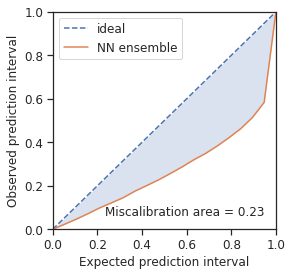

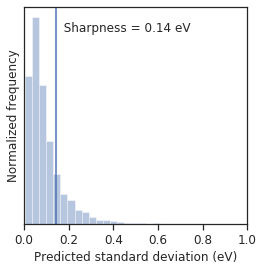

In [15]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon


# Plot settings
figsize = (width, width)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
miscalibration_area = polygon.area

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.2f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=fontsize)

# Save
plt.savefig('calibration.pdf', dpi=300, bbox_inches='tight', transparent=True)


# Plot sharpness curve
xlim = [0, 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviation (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV' % sharpness
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  ' % sharpness
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align,
                  fontsize=fontsize)

# Save
plt.savefig('sharpness.pdf', dpi=300, bbox_inches='tight', transparent=True)

# Error-bar figure
We concede that calibration curves and sharpness distributions are new concepts in the field of catalysis, and that a simple parity plot with error bars is more intuitive. As such, we create a few examples of error bar parities to help readers connect those incumbent ideas with the newer ideas of calibration and sharpness.

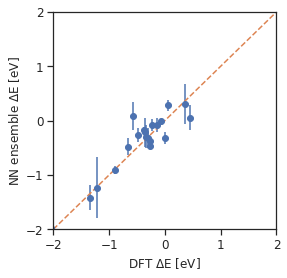

In [39]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt


# Pull a random sample of the data, because plotting thousands of these at once would look absurd
all_predictions = list(zip(targets_pred, targets_test.reshape(-1), stdevs))
samples = random.sample(all_predictions, k=20)

# Parse the samples
_preds, _targets, _stdevs = zip(*samples)
_preds = np.array(_preds)
_targets = np.array(_targets)
_stdevs = np.array(_stdevs)

# Plot
fig = plt.figure(figsize=(4, 4))
_ = plt.errorbar(_targets, _preds, yerr=2*_stdevs, fmt='o')
ax = plt.gca()

# Make a parity line
lims = [-2, 2]
_ = ax.plot(lims, lims, '--')

# Format
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.set_xticks(list(range(-2, 3)))
_ = ax.set_yticks(list(range(-2, 3)))
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Save
_ = plt.savefig('error_bar_parity.pdf', dpi=300, bbox_inches='tight', transparent=True)